## How are snow depth and air temperature related?

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
#import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import colormaps as cmaps
from readCMIP5 import *

%pylab inline

matplotlib.rcParams['figure.figsize'] = [12.0, 8.0]

Populating the interactive namespace from numpy and matplotlib


<div class="alert alert-warning">
<h3>First, read the datasets, find their means, combine them, and give them a date index.</h3>
</div>

In [2]:
snow_depth = readCMIP5Data("../data/SnowDepth_snd/", "gridded", "rcp45", "1", "snd")[2]

In [3]:
surface_temp = readCMIP5Data("../data/SeaSurfaceTemperature_tos/",'gridded','rcp45','1','tos')[2]

In [4]:
snow_depth_means = np.asarray(snow_depth.mean(axis=3).mean(axis=2))
snow_depth_means = snow_depth_means.reshape([95*12])

In [5]:
surface_temp_means = np.asarray(surface_temp.mean(axis=3).mean(axis=2))
surface_temp_means = surface_temp_means.reshape([95*12])

In [6]:
both_means = np.transpose(np.vstack((snow_depth_means, surface_temp_means)))

In [7]:
both_means_df = pd.DataFrame(both_means, columns=["snd", "tos"])

In [8]:
month_idx = pd.date_range('2005-01-01', periods=95*12, freq='1M')
both_means_df = both_means_df.set_index(month_idx)

<div class="alert alert-warning">
<h3>Seaborn, which has been imported here as "sns", is a plotting library for python that has higher-level funcationality than matplotlib. We'll use it to examine the relationship in question, beginning with the pairplot function.</h3>
</div>

/usr/lib/python2.7/dist-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


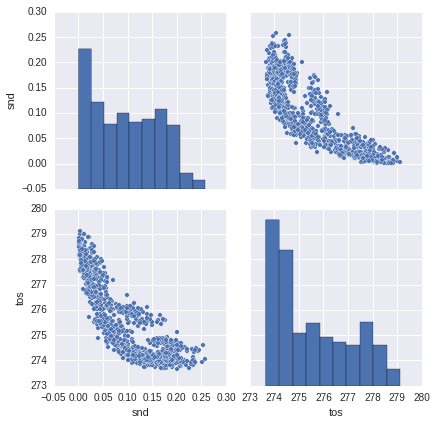

In [9]:
sns.pairplot(both_means_df)

<div class="alert alert-warning">
<h3>When exploring datasets, both plots and tables can be helpful. The correlation is a measure of how linearly related two variables are. It's not a perfect measure of relatedness but often it is a good place to start. Although the plots indicate that the relationship is not really linear, the correlation of -0.84 informs us that there is a strong negative relationship. This is not surprsigin since we might expect warmer temperatures to cause snow to melt, thus decreasing snow depth.</h3>
</div>

In [10]:
both_means_df.corr()

,snd,tos
snd,1.000000,-0.848155
tos,-0.848155,1.000000


<div class="alert alert-warning">
<h3>The pairplot function allows coloring the points according to the value of a variable. In this case, we created a new variable, for the month of the year, which was created by extracting the month from the date index.</h3>
</div>

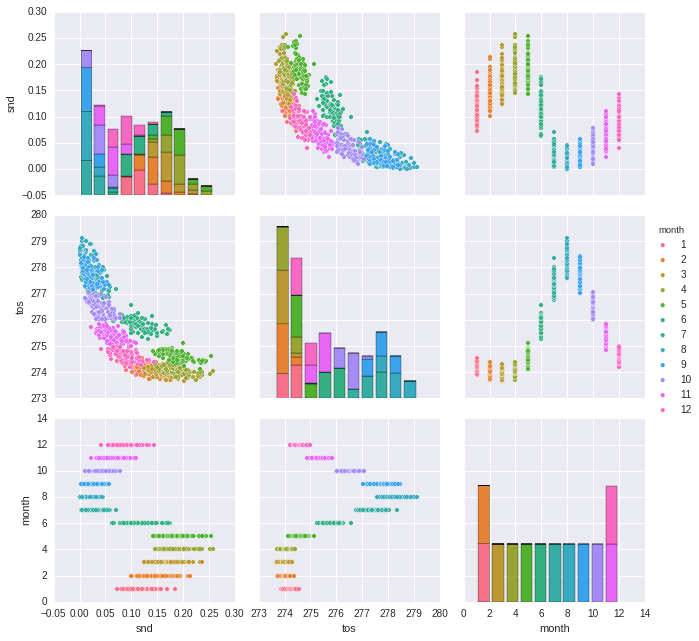

In [11]:
both_means_df["month"] = both_means_df.index.month
sns.pairplot(both_means_df, hue="month")

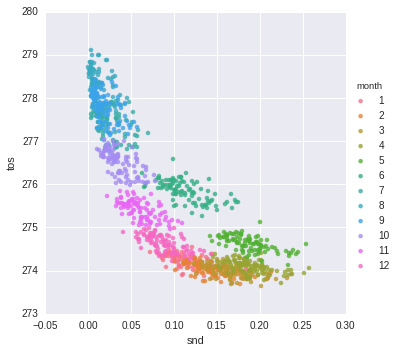

In [12]:
sns.lmplot(x="snd", y="tos", data=both_means_df, size=5, hue="month", fit_reg=False)

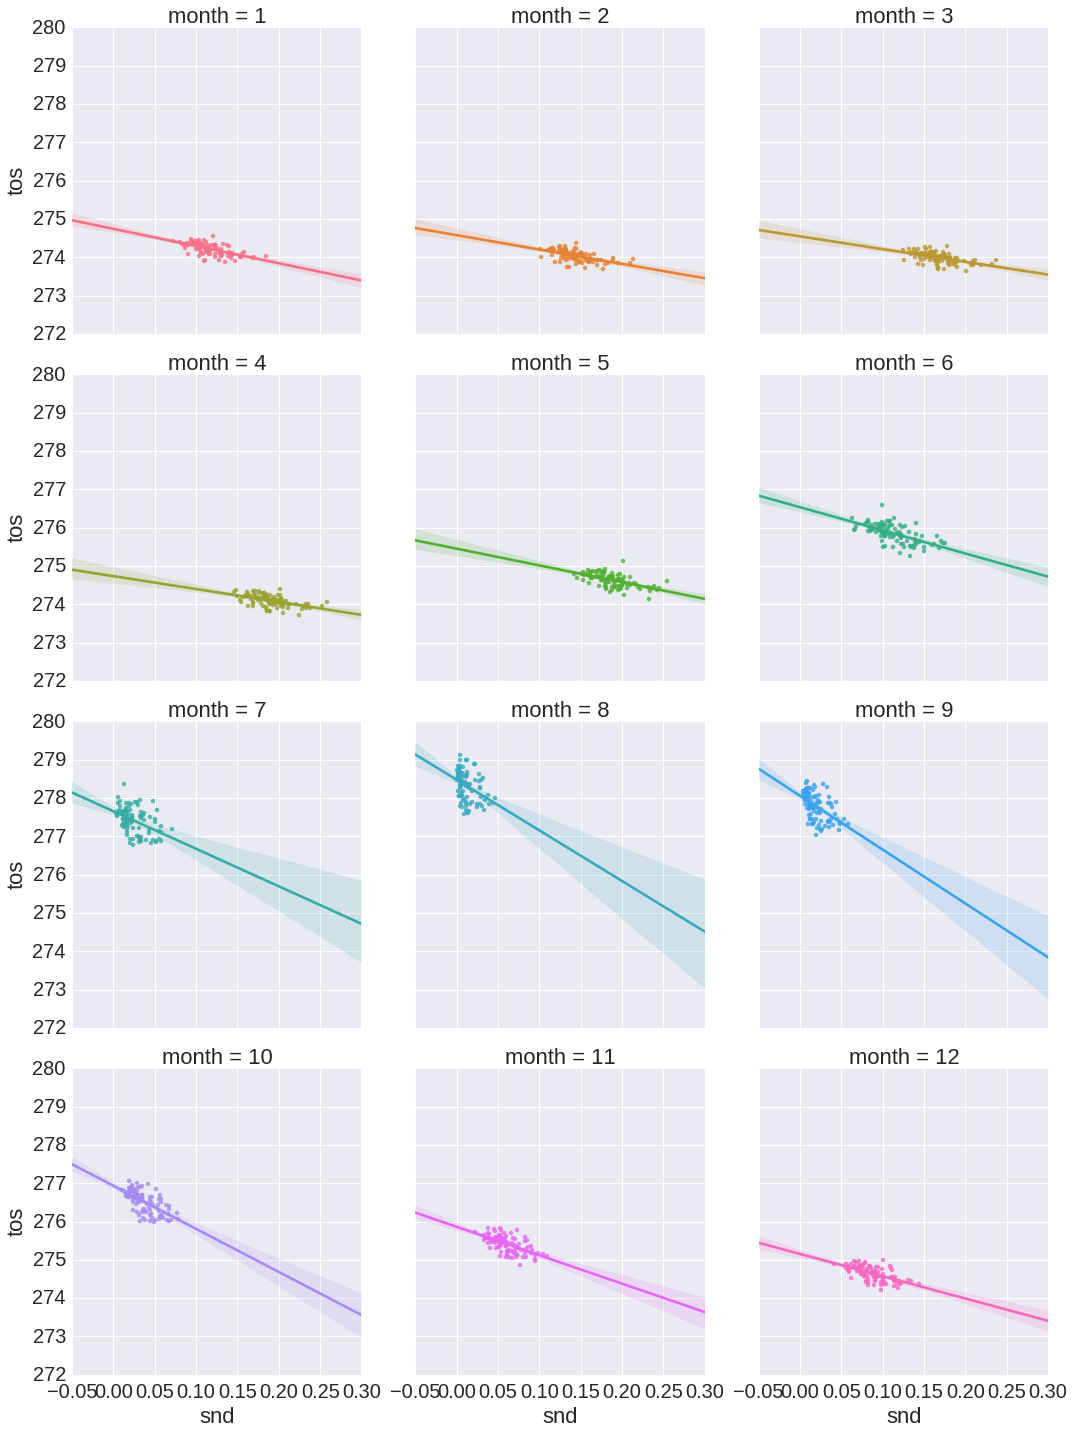

In [13]:
sns.set(font_scale=2)  #larger labels
sns.lmplot(x="snd", y="tos", data=both_means_df, size=5, col="month", hue="month", col_wrap=3)

<div class="alert alert-warning">
<h3>Another example of seaborn's advanced plotting is to show the contours of density estimates. These show where the highest concentration of points is. In particular it seems that there are two clear peaks in the concentration.</h3>
</div>

/usr/local/lib/python2.7/dist-packages/numpy/lib/function_base.py:564: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n = np.zeros(bins, ntype)
/usr/local/lib/python2.7/dist-packages/numpy/lib/function_base.py:611: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n += np.bincount(indices, weights=tmp_w, minlength=bins).astype(ntype)
/usr/lib/python2.7/dist-packages/matplotlib/collections.py:631: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):


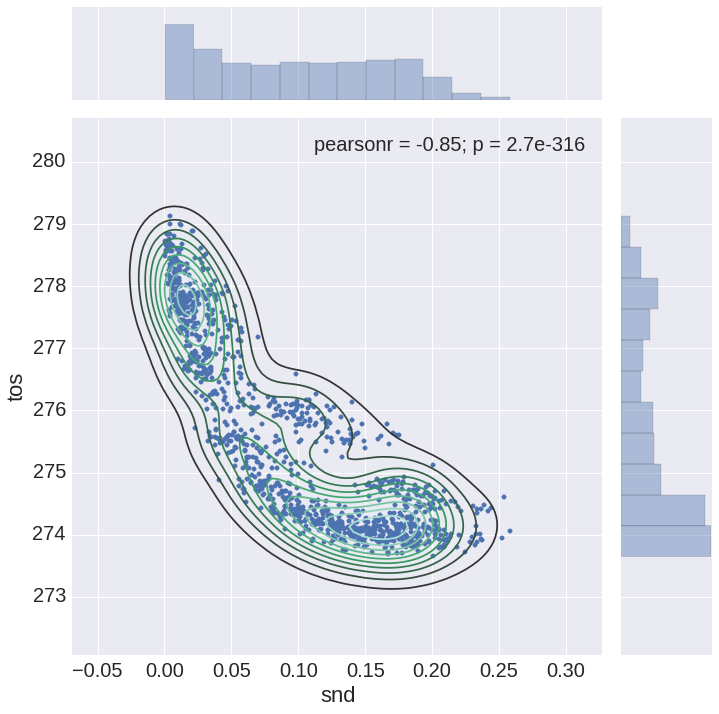

In [14]:
sns.jointplot(x="snd", y="tos", data=both_means_df, size=10).plot_joint(sns.kdeplot)